In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
import tensorflow as tf
import cv2
from tqdm import tqdm
import concurrent.futures
import multiprocessing

### Load Images

In [ ]:
image_csv = pd.read_csv('/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/GroundTruth.csv')
image_csv.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
col_names = list(image_csv.columns[1:])
print(col_names)

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']


In [ ]:
cols = image_csv.sort_values(by='image')
image_csv['labels'] = image_csv[col_names].idxmax(axis=1).apply(lambda x: col_names.index(x))

In [ ]:
result_class = image_csv['labels'].values
result_class

array([1, 1, 1, ..., 4, 1, 1])

In [ ]:
result_class = to_categorical(result_class, num_classes= len(col_names))

In [ ]:
image_csv['labels'].value_counts()

1    6705
0    1113
4    1099
2     514
3     327
6     142
5     115
Name: labels, dtype: int64

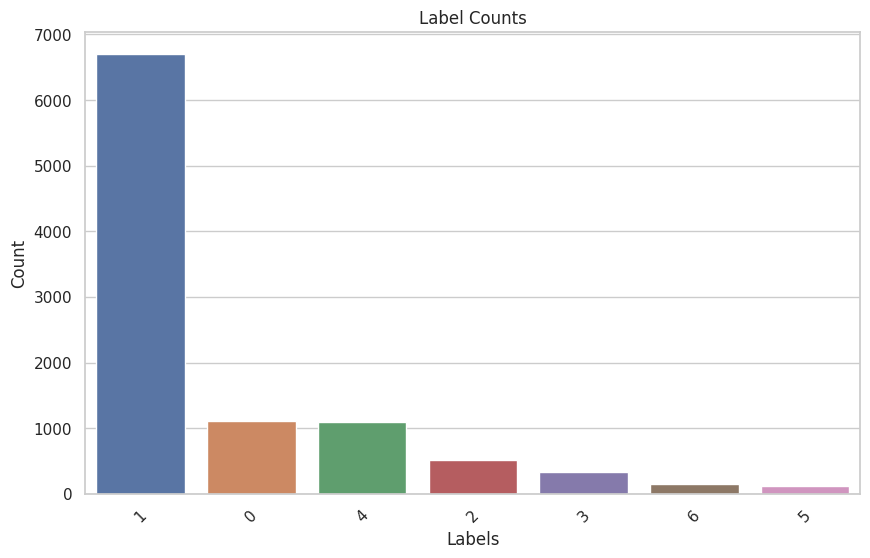

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'labels' is a column in your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.countplot(x='labels', data=image_csv, order=image_csv['labels'].value_counts().index)
plt.title('Label Counts')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
img_paths = list(glob('/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/images/*.jpg'))
mask_paths = list(glob('/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/masks/*.png'))

In [ ]:
img_paths = sorted(img_paths)
mask_paths = sorted(mask_paths)

In [ ]:
print(len(img_paths))
print(len(mask_paths))

10015
10015


In [ ]:
print(img_paths[:5], mask_paths[:5])

['/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/images/ISIC_0024306.jpg', '/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/images/ISIC_0024307.jpg', '/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/images/ISIC_0024308.jpg', '/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/images/ISIC_0024309.jpg', '/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/images/ISIC_0024310.jpg'] ['/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/masks/ISIC_0024306_segmentation.png', '/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/masks/ISIC_0024307_segmentation.png', '/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Train/masks/ISIC_0024308_segmentation.png', '/content/drive/MyDrive/cs770-final-project-skin-l

In [ ]:
img_size = (128, 128)

def load_and_preprocess_image(path):
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img

def load_and_preprocess_images(paths):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        images = list(tqdm(executor.map(load_and_preprocess_image, paths), total=len(paths)))
    return np.array(images)

images = load_and_preprocess_images(img_paths)
masks = load_and_preprocess_images(mask_paths)

100%|██████████| 10015/10015 [16:59<00:00,  9.82it/s]


In [ ]:
masks = np.array([cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY) for img in masks])
# Ensure the shape of the mask_images is (num_samples, height, width, 1)
masks = masks.reshape(masks.shape + (1,))

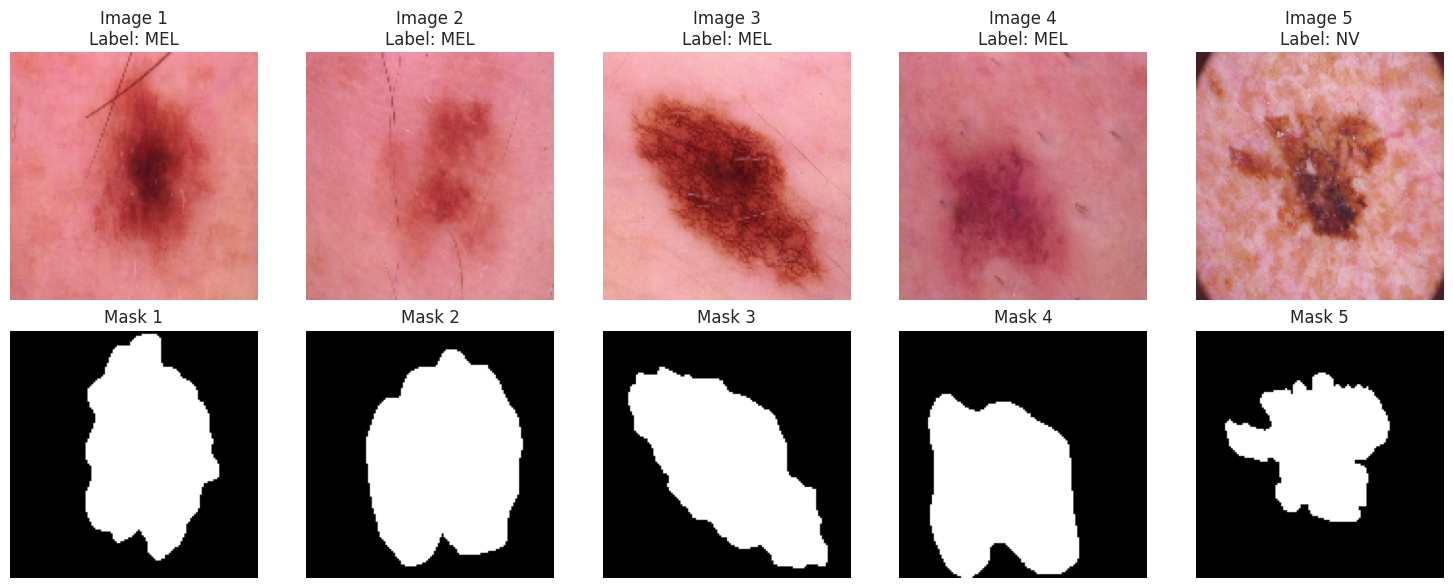

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have 'images', 'masks', 'result_class', and 'col_names' arrays
num_pairs = min(len(images), len(masks), len(result_class), 5)  # Display up to 5 pairs

fig, axes = plt.subplots(2, num_pairs, figsize=(15, 6))

for i in range(num_pairs):
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')

    # Assuming result_class is an array of predicted class labels
    predicted_class_index = int(result_class[i][0])
    predicted_class_name = col_names[predicted_class_index]

    axes[0, i].set_title(f'Image {i + 1}\nLabel: {predicted_class_name}')

    axes[1, i].imshow(masks[i], cmap='gray')  # Assuming masks are grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Mask {i + 1}')

plt.tight_layout()
plt.show()


In [ ]:
X_train, X_test, y_train, y_test, y_seg_train, y_seg_test = train_test_split(images, result_class, masks, test_size=0.25, random_state=42)

In [ ]:
from keras.applications import ResNet50
from keras.layers import Input, Conv2D, UpSampling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras.utils import to_categorical

def create_combined_model(input_size=(128, 128, 3), num_classes_seg=2, num_classes_cls=len(col_names)):
    inputs = Input(input_size)

    # ResNet50-based Encoder for both Segmentation and Classification
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Freeze the layers of the ResNet50 model
    for layer in base_model.layers:
        layer.trainable = False

    # Encoder part for Segmentation
    x_seg = base_model.output
    x_seg = Conv2D(512, 3, activation='relu', padding='same')(x_seg)
    x_seg = BatchNormalization()(x_seg)
    x_seg = Conv2D(512, 3, activation='relu', padding='same')(x_seg)
    x_seg = BatchNormalization()(x_seg)

    # Decoder part for Segmentation
    x_seg = UpSampling2D(size=(2, 2))(x_seg)
    x_seg = concatenate([x_seg, base_model.get_layer('conv4_block6_out').output], axis=-1)
    x_seg = Conv2D(256, 3, activation='relu', padding='same')(x_seg)
    x_seg = BatchNormalization()(x_seg)
    x_seg = Conv2D(256, 3, activation='relu', padding='same')(x_seg)
    x_seg = BatchNormalization()(x_seg)

    x_seg = UpSampling2D(size=(2, 2))(x_seg)
    x_seg = concatenate([x_seg, base_model.get_layer('conv3_block4_out').output], axis=-1)
    x_seg = Conv2D(128, 3, activation='relu', padding='same')(x_seg)
    x_seg = BatchNormalization()(x_seg)
    x_seg = Conv2D(128, 3, activation='relu', padding='same')(x_seg)
    x_seg = BatchNormalization()(x_seg)

    x_seg = UpSampling2D(size=(2, 2))(x_seg)
    x_seg = concatenate([x_seg, base_model.get_layer('conv2_block3_out').output], axis=-1)
    x_seg = Conv2D(64, 3, activation='relu', padding='same')(x_seg)
    x_seg = BatchNormalization()(x_seg)
    x_seg = Conv2D(64, 3, activation='relu', padding='same')(x_seg)
    x_seg = BatchNormalization()(x_seg)

    x_seg = UpSampling2D(size=(2, 2))(x_seg)
    x_seg = concatenate([x_seg, base_model.get_layer('conv1_relu').output], axis=-1)
    x_seg = Conv2D(64, 3, activation='relu', padding='same')(x_seg)
    x_seg = BatchNormalization()(x_seg)
    x_seg = Conv2D(64, 3, activation='relu', padding='same')(x_seg)
    x_seg = BatchNormalization()(x_seg)

    # Adjust the final upsampling and convolution to get (128, 128, 1)
    x_seg = UpSampling2D(size=(2, 2))(x_seg)
    x_seg = Conv2D(1, 3, activation='sigmoid', padding='same', name='seg_output')(x_seg)

    # Flatten and Dense layers for Classification
    x_cls = Flatten()(base_model.output)
    x_cls = Dense(512, activation='relu')(x_cls)
    x_cls = BatchNormalization()(x_cls)
    x_cls = Dropout(0.5)(x_cls)

    cls_outputs = Dense(num_classes_cls, activation='softmax', name='cls_output')(x_cls)

    # Create the combined model
    combined_model = Model(inputs=inputs, outputs=[x_seg, cls_outputs])

    # Compile the model with appropriate loss functions and metrics
    combined_model.compile(optimizer=Adam(),
                           loss={'seg_output': 'binary_crossentropy', 'cls_output': 'categorical_crossentropy'},
                           metrics={'seg_output': [MeanIoU(num_classes=2)], 'cls_output': 'accuracy'})

    return combined_model

# Create the combined model with adjusted upsampling
combined_model_resnet = create_combined_model()


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
combined_model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback
checkpoint_filepath = 'best_model.h5'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='cls_output_accuracy',  # Monitor accuracy for the classification task
    save_best_only=True,  # Save only the best model
    mode='max',  # Save the model when the monitored metric is at its maximum
    verbose=1
)

In [ ]:
history = combined_model_resnet.fit(
    X_train,
    {'seg_output': y_seg_train, 'cls_output': y_train},
    epochs=10,
    batch_size=16,
    validation_data=(X_test, {'seg_output': y_seg_test, 'cls_output': y_test}),
    callbacks=[model_checkpoint],  # Include the ModelCheckpoint callback
    # other parameters as needed
)

Epoch 1/10
470/470 [==============================] - ETA: 0s - loss: 1.3045 - seg_output_loss: 0.2483 - cls_output_loss: 1.0562 - seg_output_mean_io_u: 0.4255 - cls_output_accuracy: 0.6580
Epoch 1: cls_output_accuracy improved from -inf to 0.65797, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


470/470 [==============================] - 66s 97ms/step - loss: 1.3045 - seg_output_loss: 0.2483 - cls_output_loss: 1.0562 - seg_output_mean_io_u: 0.4255 - cls_output_accuracy: 0.6580 - val_loss: 6.2503 - val_seg_output_loss: 2.0067 - val_cls_output_loss: 4.2436 - val_seg_output_mean_io_u: 0.3648 - val_cls_output_accuracy: 0.6681
Epoch 2/10
470/470 [==============================] - ETA: 0s - loss: 1.0826 - seg_output_loss: 0.1882 - cls_output_loss: 0.8943 - seg_output_mean_io_u: 0.4181 - cls_output_accuracy: 0.6936
Epoch 2: cls_output_accuracy improved from 0.65797 to 0.69365, saving model to best_model.h5
470/470 [==============================] - 41s 87ms/step - loss: 1.0826 - seg_output_loss: 0.1882 - cls_output_loss: 0.8943 - seg_output_mean_io_u: 0.4181 - cls_output_accuracy: 0.6936 - val_loss: 53.1054 - val_seg_output_loss: 51.7383 - val_cls_output_loss: 1.3671 - val_seg_output_mean_io_u: 0.2510 - val_cls_output_accuracy: 0.6318
Epoch 3/10
470/470 [=============================

In [ ]:
test_dir = "/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Test/ISIC2018_Task3_Test_Input"
test_paths = glob(test_dir+"/*.jpg")
print(len(test_paths))

1512


In [ ]:
test_result = pd.read_csv("/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Test/ISIC2018_Task3_Test_GroundTruth/ISIC2018_Task3_Test_GroundTruth.csv")
test_result['column_with_1'] = test_result[col_names].idxmax(axis=1).apply(lambda x: col_names.index(x))
actual = test_result['column_with_1'].values
print(actual)

[1 1 4 ... 3 4 2]


In [ ]:
img_size = (128, 128)

def load_and_preprocess_image(path):
    img = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    img = img / 255.0
    return img

def load_and_preprocess_images(paths):
    with concurrent.futures.ProcessPoolExecutor() as executor:
        images = list(tqdm(executor.map(load_and_preprocess_image, paths), total=len(paths)))
    return np.array(images)

test_images = load_and_preprocess_images(test_paths)

100%|██████████| 1512/1512 [01:08<00:00, 21.92it/s]


In [ ]:
test_images_array = np.stack(test_images, axis=0)

predictions = combined_model_resnet.predict(test_images_array)[1]

48/48 [==============================] - 5s 54ms/step


In [ ]:
predictions = np.argmax(predictions, axis=1)

In [ ]:
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.60      1.00      0.75       909
           2       0.00      0.00      0.00        93
           3       0.00      0.00      0.00        43
           4       0.00      0.00      0.00       217
           5       0.00      0.00      0.00        44
           6       0.00      0.00      0.00        35

    accuracy                           0.60      1512
   macro avg       0.09      0.14      0.11      1512
weighted avg       0.36      0.60      0.45      1512



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Test Segmentation

In [ ]:
test_dir = "/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Test/ISBI2016_ISIC_Part1_Test_Data"
test_paths = glob(test_dir+"/*.jpg")
test_masks_dir = "/content/drive/MyDrive/cs770-final-project-skin-lesion-segmentation/Project_Data/Test/ISBI2016_ISIC_Part1_Test_GroundTruth"
test_masks_paths = glob(test_masks_dir+"/*.png")
print(len(test_masks_paths))
print(len(test_paths))

379
379


In [ ]:
test_images = load_and_preprocess_images(test_paths)
test_masks = load_and_preprocess_images(test_masks_paths)

100%|██████████| 379/379 [00:43<00:00,  8.70it/s]


In [ ]:
test_images_array = np.stack(test_images, axis=0)

predictions = combined_model_resnet.predict(test_images_array)[0]

12/12 [==============================] - 2s 182ms/step


In [ ]:
threshold = 0.5 # Adjust as needed
segmentation_mask = (predictions > threshold).astype(np.uint8)

<ipython-input-36-1423e7bc250e>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


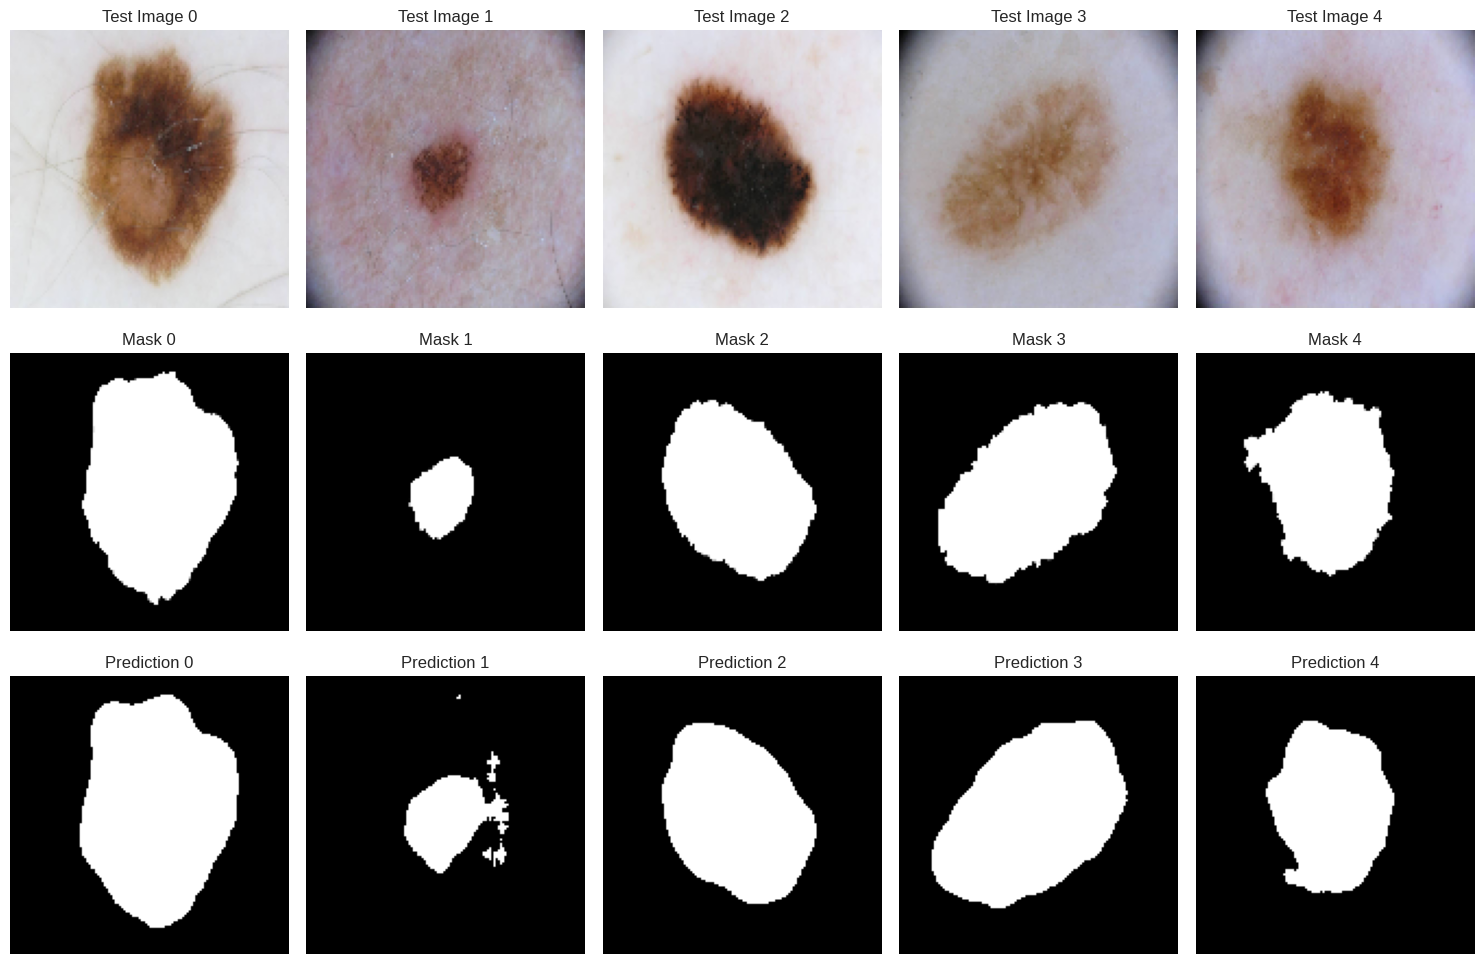

In [ ]:
import matplotlib.pyplot as plt

# Choose some random indices to visualize
indices_to_visualize = [0, 1, 2, 3, 4]

# Set a custom style
plt.style.use('seaborn-darkgrid')

# Create subplots with a different layout
fig, axes = plt.subplots(3, len(indices_to_visualize), figsize=(15, 10))

# Plot the images, masks, and predictions
for i, idx in enumerate(indices_to_visualize):
    # Plot Test Image
    axes[0, i].imshow(test_images[idx])
    axes[0, i].set_title(f'Test Image {idx}')
    axes[0, i].axis('off')

    # Plot Mask
    axes[1, i].imshow(test_masks[idx].squeeze(), cmap='gray')
    axes[1, i].set_title(f'Mask {idx}')
    axes[1, i].axis('off')

    # Plot Prediction
    axes[2, i].imshow(segmentation_mask[idx].squeeze(), cmap='gray')
    axes[2, i].set_title(f'Prediction {idx}')
    axes[2, i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
